In [105]:
# please install bokeh and umap before running this notebook :)
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE

from sklearn import datasets
from matplotlib import offsetbox

import umap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
import random

random.seed(2021)

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
%matplotlib inline

In [106]:
df = pd.read_csv('data/train.csv')

## Data cleaning + preprocessing 

In [107]:
COLS_TO_DROP = list((df.isna().sum(axis=0)/df.shape[0]).where(lambda x: x>0.2).dropna().index) + ['Id', 'YrSold', 'YearBuilt', 'GarageYrBlt']

In [108]:
# Deleting some outliers which we found previously 
df.sort_values(by = 'GrLivArea', ascending = False)[:2]
df = df.drop(df[df['Id'] == 1299].index)
df = df.drop(df[df['Id'] == 524].index)

In [109]:
# Found categorical columns where one level appears more than in 90% of cases
cat_col_mask_to_drop = []
for c in df.select_dtypes(np.object).columns:
    cat_col_mask_to_drop.append((df[c].value_counts()/df.shape[0])[0] > 0.9)

In [110]:
COLS_TO_DROP.extend(list(df.select_dtypes(np.object).columns[cat_col_mask_to_drop]))

In [111]:
df.drop(COLS_TO_DROP, axis=1, inplace=True)

In [112]:
# just for viz 
df['SalePriceBinary'] = df['SalePrice'].apply(lambda x: '>150000' if x>150000 else '150000<=')

In [113]:
# Splitting columns on groups: countinious, nominal and ordinal
continious_cols = ['MoSold', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'OpenPorchSF', 
    'GarageArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LowQualFinSF', 'TotalBsmtSF', 'BsmtUnfSF',
    'WoodDeckSF', 'BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea', 'LotArea', 'LotFrontage']
nominal_cols = list(df.select_dtypes(np.object))
nominal_cols.remove('SalePriceBinary')
ordinal_cols = list(df.columns.difference(continious_cols + nominal_cols + ['SalePrice', 'SalePriceBinary']))

y = ['SalePriceBinary']

In [114]:
class RareLabelEncoder(BaseEstimator, TransformerMixin):
    """
    Find infrequent category levels and encode them to one value
    """

    def __init__(self, tol=0.05, n_categories=5, replace_with='Rare'):
        self.tol = tol
        self.replace_with = replace_with
        self.n_categories = n_categories

    def fit(self, X):
        self.cols = X.columns
        self.encoder_dict = {}

        for c in self.cols:
            if X[c].nunique() > self.n_categories:
                t = pd.Series(X[c].value_counts() / np.float(len(X)))
                freq_idx = t[t >= self.tol].index
                self.encoder_dict[c] = freq_idx

        return self

    def transform(self, X):
        for feature in self.cols:
            if feature in self.encoder_dict.keys():
                X[feature] = np.where(
                    X[feature].isin(self.encoder_dict[feature]),
                    X[feature],
                    self.replace_with,
                )
        return X

In [115]:
rle = RareLabelEncoder()

rle.fit_transform(df[nominal_cols])

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,GarageType,GarageFinish,GarageQual,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,No,GLQ,Unf,Ex,Gd,Attchd,RFn,TA,WD,Normal
1,RL,Reg,Lvl,FR2,Rare,Feedr,1Fam,1Story,Gable,MetalSd,...,Gd,ALQ,Unf,Ex,TA,Attchd,RFn,TA,WD,Normal
2,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,Mn,GLQ,Unf,Ex,Gd,Attchd,RFn,TA,WD,Normal
3,RL,IR1,Lvl,Corner,Rare,Norm,1Fam,2Story,Gable,Wd Sdng,...,No,ALQ,Unf,Gd,Gd,Detchd,Unf,TA,WD,Abnorml
4,RL,IR1,Lvl,FR2,Rare,Norm,1Fam,2Story,Gable,VinylSd,...,Av,GLQ,Unf,Ex,Gd,Attchd,RFn,TA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,...,No,Unf,Unf,Ex,TA,Attchd,RFn,TA,WD,Normal
1456,RL,Reg,Lvl,Inside,NWAmes,Norm,1Fam,1Story,Gable,Plywood,...,No,ALQ,Rare,TA,TA,Attchd,Unf,TA,WD,Normal
1457,RL,Reg,Lvl,Inside,Rare,Norm,1Fam,2Story,Gable,Rare,...,No,GLQ,Unf,Ex,Gd,Attchd,RFn,TA,WD,Normal
1458,RL,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,Hip,MetalSd,...,Mn,GLQ,Rare,Gd,Gd,Attchd,Unf,TA,WD,Normal


In [116]:
# Define pipelines for preprocessing different types of features

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

cat_pipe = Pipeline([
    ('rare_label_enc', RareLabelEncoder()),
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(sparse=False)), 
    ('variance_trsh', VarianceThreshold(threshold=.97 * (1 - .97)))
])

ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, nominal_cols),
    ('ord', ord_pipe, ordinal_cols),
    ('num', num_pipe, continious_cols)
])

In [117]:
X = pipe.fit_transform(df)

In [118]:
X.shape

(1458, 132)

In [119]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.52125624,
        -0.20393408, -0.22808532],
       [ 0.        ,  1.        ,  0.        , ..., -0.57440466,
        -0.08725172,  0.48507784],
       [ 0.        ,  1.        ,  0.        , ...,  0.33119261,
         0.08016212, -0.08545269],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.57440466,
        -0.14386803, -0.18054111],
       [ 0.        ,  1.        ,  0.        , ..., -0.57440466,
        -0.07538055, -0.08545269],
       [ 0.        ,  1.        ,  0.        , ..., -0.57440466,
        -0.05305871,  0.24735679]])

# PCA

In [67]:
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

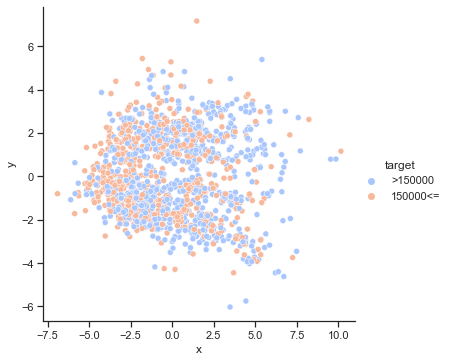

In [68]:
plot_df = pd.DataFrame.from_records(data=new_X[:,:2],columns=["x","y"])
plot_df["target"] = df[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [69]:
pca.explained_variance_ratio_.sum()

0.24411618153001757

In [70]:
pca = PCA(n_components=0.95).fit(X)

len(pca.explained_variance_ratio_)

59

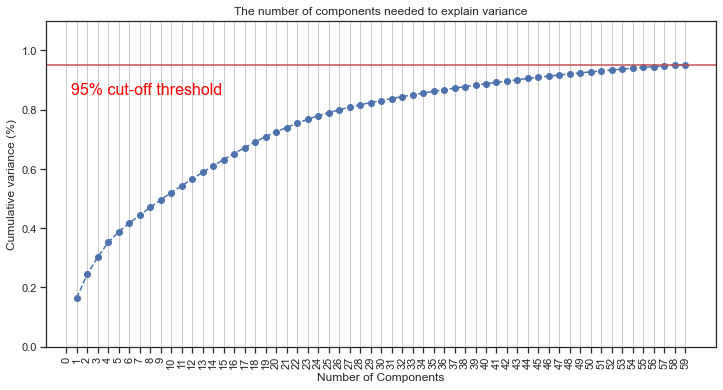

In [71]:
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

# SVD
[SVD as simply as it possible](http://gregorygundersen.com/blog/2018/12/10/svd/)  
Singular value decomposition is a method of decomposing a matrix into three other matrices:
![](https://miro.medium.com/max/318/0*i4rDKIAE0o1ZXtBd.)
Where:
- A is an m × n matrix
- U is an m × n orthogonal matrix (left singular vectors)
- S is an n × n diagonal matrix (singular values)
- V is an n × n orthogonal matrix (right singular vectors)

The diagonal values in the S matrix are known as the singular values of the original matrix A. The columns of the U matrix are called the left-singular vectors of A, and the columns of V are called the right-singular vectors of A. There is also a relationship between PCA and SVD (only if A is centered, singular values are related to the eigenvalues of covariance matrix via $ 𝜆_{i}=s^2_{i}/(𝑛−1)$), you can find good explanations here: [link](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca).

Truncated SVD is different from regular SVDs in that it produces a factorization where the number of columns is equal to the specified truncation. For example, given an m x n matrix, SVD will produce matrices with n columns, whereas truncated SVD will produce matrices with the specified number of columns. This is how the dimensionality is reduced.

In [72]:
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(X)

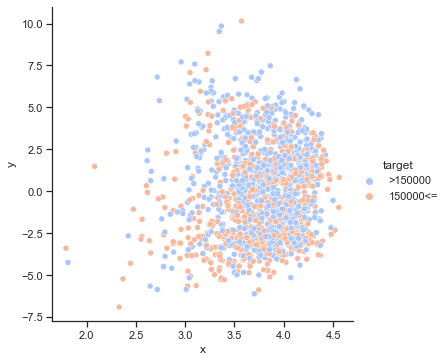

In [73]:
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = df[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [74]:
svd.explained_variance_ratio_.sum()

0.16782756161180026

# UMAP
[Understanding UMAP](https://pair-code.github.io/understanding-umap/)  
[Scipy 2018 talk](https://www.youtube.com/watch?v=nq6iPZVUxZU)  

UMAP has several hyperparameters that can have a significant impact on the resulting embedding. 
 
* `n_neighbors`  
This parameter controls how UMAP balances local versus global structure in the data. It does this by constraining the size of the local neighborhood UMAP will look at when attempting to learn the manifold structure of the data. This means that low values of n_neighbors will force UMAP to concentrate on very local structure (potentially to the detriment of the big picture), while large values will push UMAP to look at larger neighborhoods of each point when estimating the manifold structure of the data, losing fine detail structure for the sake of getting the broader of the data.
* `min_dist`  
The min_dist parameter controls how tightly UMAP is allowed to pack points together. It, quite literally, provides the minimum distance apart that points are allowed to be in the low dimensional representation. This means that low values of min_dist will result in clumpier embeddings. Larger values of min_dist will prevent UMAP from packing points together and will focus on the preservation of the broad topological structure instead.
* `n_components`  
As is standard for many scikit-learn dimension reduction algorithms UMAP provides a n_components parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into.


In [75]:
embedding = umap.UMAP(n_neighbors=20, min_dist=0.15).fit_transform(X)

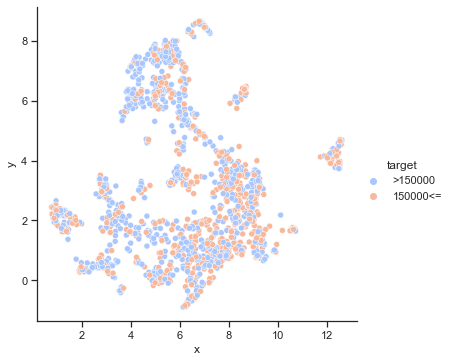

In [76]:
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = df[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

# t-SNE

Some usefull links:  
[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)  
[t-SNE clearly explained](https://erdem.pl/2020/04/t-sne-clearly-explained)  

Most important parameter: 
* `perplexity`  
Perplexity is perhaps the most important parameter in t-SNE and can reveal different aspects of the data. The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Considered loosely, it can be thought of as the balance between preserving the global and the local structure of the data. Larger datasets usually require a larger perplexity. 


In [77]:
tsne = TSNE()
tsne_X = tsne.fit_transform(X)

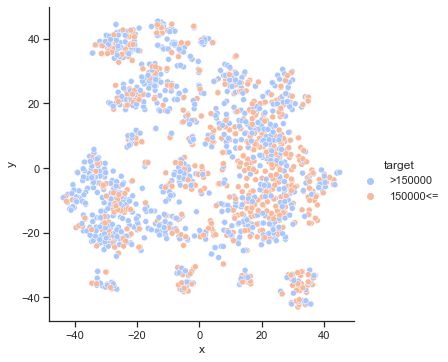

In [78]:
plot_df = pd.DataFrame.from_records(data=tsne_X,columns=["x","y"])
plot_df["target"] = df[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [79]:
pca = PCA(n_components=0.95)
new_X = pca.fit_transform(X)

tsne = TSNE(n_components=2)
tsne_X_pca = tsne.fit_transform(new_X)

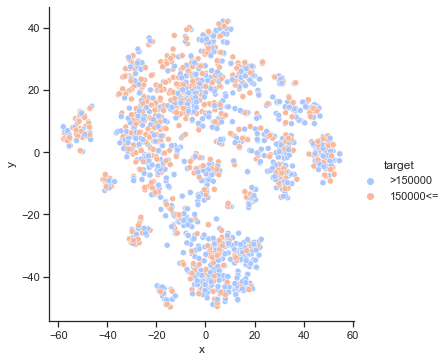

In [80]:
plot_df = pd.DataFrame.from_records(data=tsne_X_pca,columns=["x","y"])
plot_df["target"] = df[y]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

# MNIST 
[kaggle link](https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv)

The MNIST handwritten digits dataset consists of binary images of a single handwritten digit (0-9) of size $28\times 28$. The provided training set has 60,000 images (we will use only 6000 sample), and the testing set has 10,000 images.

We can think of each digit as a point in a higher-dimensional space. If we take an image from this dataset and rasterize it into a $784\times 1$ vector, then it becomes a point in 784-dimensional space. That’s impossible to visualize in that higher space!


In [81]:
df = pd.read_csv("data/mnist_train_sample6000.csv")

In [82]:
for i in df.iloc[:,1:].values[:1].reshape(1, 28,28)[0]:
    print(" ".join(list([str(x) for x in i])))

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 38 43 105 255 253 253 253 253 253 174 6 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 43 139 224 226 252 253 252 252 252 252 252 252 158 14 0 0 0 0 0
0 0 0 0 0 0 0 0 0 178 252 252 252 252 253 252 252 252 252 252 252 252 59 0 0 0 0 0
0 0 0 0 0 0 0 0 0 109 252 252 230 132 133 132 132 189 252 252 252 252 59 0 0 0 0 0
0 0 0 0 0 0 0 0 0 4 29 29 24 0 0 0 0 14 226 252 252 172 7 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 85 243 252 252 144 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 88 189 252 252 252 14 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 91 212 247 252 252 252 204 9 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 32 125 193 193 193 253 252 252 252 238 102 28 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 45 222 252 252 252 252 253 252 252 2

In [83]:
df.iloc[:,1:].values[:1].reshape(1, 28,28)

array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  38,
          43, 105, 255, 253, 253, 253, 253, 253, 174,   6,   0,   0,
           0,   0,   0

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 35.9 MB


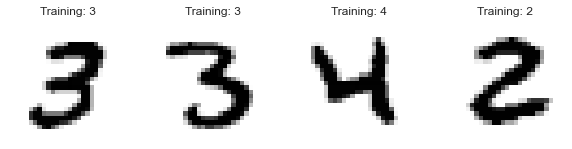

In [85]:
df.iloc[:,1:]

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, df.iloc[:,1:].values[:4].reshape(4, 28,28), df.iloc[:4,0].values):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [86]:
images = df.iloc[:,1:].values.reshape(df.shape[0], 28,28)

In [87]:
# digits = datasets.load_digits()
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
n_samples, n_features = X.shape


# function that will produce a nice visualization of our data
def embedding_plot(M, title):
    x_min, x_max = np.min(M, axis=0), np.max(M, axis=0)
    M = (M - x_min) / (x_max - x_min)
 
    plt.figure(figsize=(15,10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(M[:,0], M[:,1], lw=0, s=40, c=y/10, alpha=0.7, cmap='viridis_r')
 
    shown_images = np.array([[1., 1.]])
    for i in range(M.shape[0]):
        if np.min(np.sum((M[i] - shown_images) ** 2, axis=1)) < 1e-2: continue
        shown_images = np.r_[shown_images, [M[i]]]
        ax.add_artist(offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r), M[i]))
 
    plt.xticks([]), plt.yticks([])
    plt.title(title)

In [88]:
n_samples, n_features

(6000, 784)

## PCA

In [89]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

Wall time: 288 ms


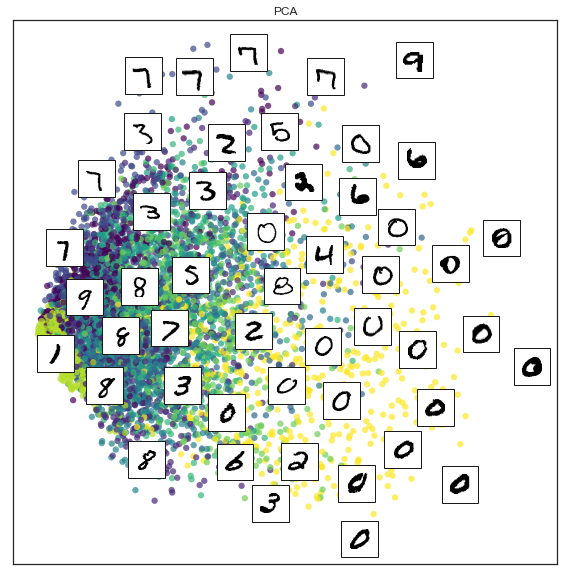

In [90]:
embedding_plot(X_pca, "PCA")
plt.show()

In [91]:
pca.explained_variance_ratio_.sum()

0.1078049470642047

## t-SNE

In [92]:
%%time
X_tsne = TSNE(n_components=2, perplexity=10).fit_transform(X)

Wall time: 32.8 s


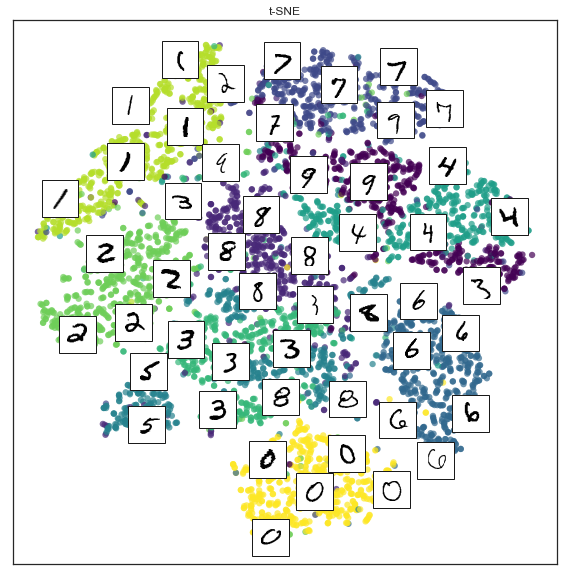

In [93]:
embedding_plot(X_tsne,"t-SNE")
plt.show()

In [94]:
%%time
X_tsne = TSNE(n_components=2, perplexity=50).fit_transform(X)

Wall time: 51.7 s


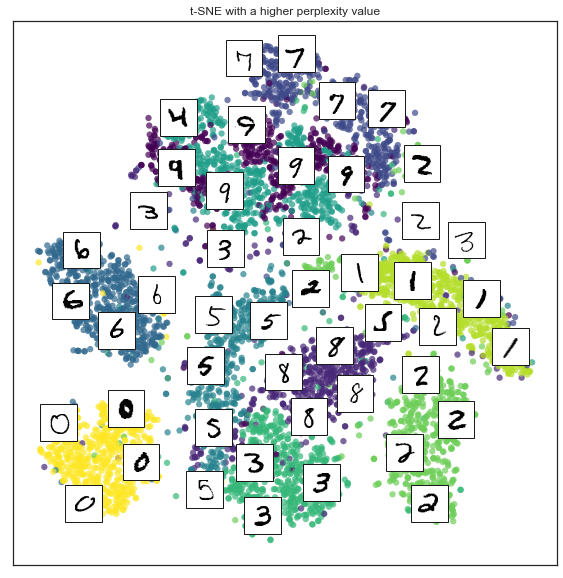

In [95]:
embedding_plot(X_tsne,"t-SNE with a higher perplexity value")
plt.show()

## t-SNE + PCA preproccesing

In [96]:
%%time
X_pcatsne = TSNE(n_components=2, perplexity=10).fit_transform(
    PCA(n_components=0.95).fit_transform(StandardScaler().fit_transform(X))
)

Wall time: 39.7 s


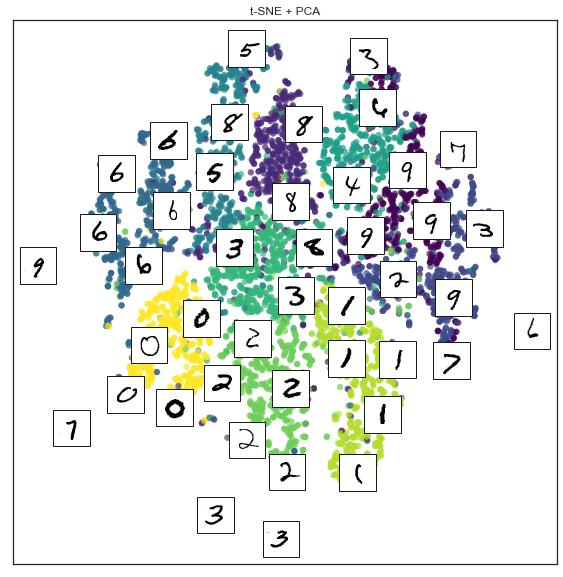

In [97]:
embedding_plot(X_pcatsne,"t-SNE + PCA")
plt.show()

## UMAP

In [98]:
%%time
umap_tr = umap.UMAP(n_neighbors=15, min_dist=0.1)
X_umap = umap_tr.fit_transform(X)

Wall time: 8.16 s


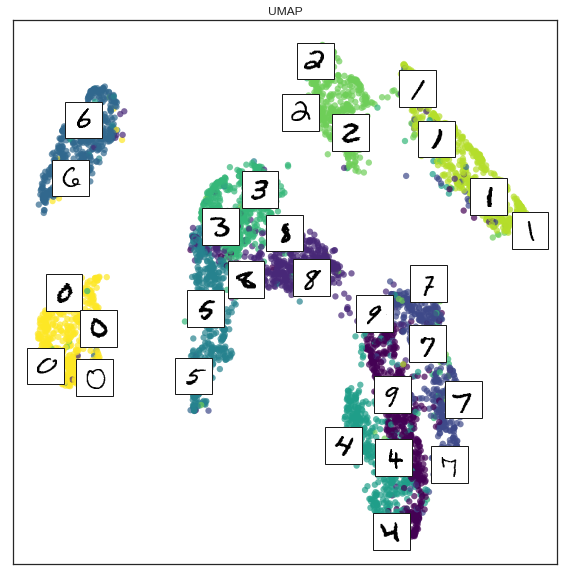

In [99]:
embedding_plot(X_umap, "UMAP")
plt.show()

###  Additional fun with interective plots

In [100]:
from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

ModuleNotFoundError: No module named 'bokeh'

In [ ]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [ ]:
digits_df = pd.DataFrame(X_umap, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in y]
digits_df['image'] = list(map(embeddable_image, X.reshape(X.shape[0], 28,28)))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in y],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of MNIST dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)